# Kristins Alex 

## Imports

In [1]:
import os
from datetime import datetime
from dataclasses import dataclass

import talos as ta
from talos.model import lr_normalizer
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.compat.v1.keras import backend as K
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers import ReLU, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.initializers import glorot_uniform

available_gpus = tf.config.experimental.list_physical_devices('GPU')
built_with_cuda = tf.test.is_built_with_cuda()

if not (not available_gpus) & built_with_cuda:
    print("The installed version of TensorFlow {} includes GPU support.\n".format(tf.__version__))
    print("Num GPUs Available: ", len(available_gpus), "\n")
else:
    print("The installed version of TensorFlow {} does not include GPU support.\n".format(tf.__version__))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

from numpy.random import seed
seed(1)
tf.random.set_seed(1)

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
config.gpu_options.per_process_gpu_memory_fraction = 0.99
sess = tf.compat.v1.Session(config = config)
K.set_session(sess)

Using TensorFlow backend.


The installed version of TensorFlow 2.1.0 includes GPU support.

Num GPUs Available:  2 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10240550769039494501
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 9105744200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6347138127791968951
physical_device_desc: "device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:17:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 9104897474
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12093766622541448315
physical_device_desc: "device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:65:00.0, compute capability: 7.5"
]


## AlexNet

In [2]:
def alexnet(activation, leaky_alpha):
        
    if activation == 'leakyrelu':
        activation_layer = LeakyReLU(alpha = leaky_alpha)
    elif activation == 'relu':
        activation_layer = ReLU()
    
    model = Sequential([
        Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,Global.num_image_channels)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=384, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D(pool_size=(3,3), strides=(2,2)),
        Flatten(),
        Dense(4096, activation=activation_layer),
        Dropout(0.5),#todo
        Dense(4096, activation=activation_layer),
        Dropout(0.5),#todo
        Dense(units = 2, activation=activation_layer)
        #Dense(10, activation='softmax')
    ])
    return model

### Generierung Modell (Angepasst für Talos)

In [3]:
def gen_model(x_train, y_train, x_val, y_val, params):
    
    K.clear_session()

    model = alexnet(params['activation'], params['leaky_alpha'])
        
    model.compile(
        optimizer = params['optimizer'](lr = lr_normalizer(params['lr'], params['optimizer'])), 
        loss = Global.loss_funktion, 
        metrics = get_reduction_metric(Global.reduction_metric)
    )
    train_generator, valid_generator = create_data_pipline(params['batch_size'], params['samples'])
    tg_steps_per_epoch = train_generator.n // train_generator.batch_size
    vg_validation_steps = valid_generator.n // valid_generator.batch_size
    print('Steps per Epoch: {}, Validation Steps: {}'.format(tg_steps_per_epoch, vg_validation_steps))
    
    startTime = datetime.now()
    out = model.fit(
        x = train_generator,
        epochs = params['epochs'],
        validation_data = valid_generator,
        steps_per_epoch = tg_steps_per_epoch,
        validation_steps = vg_validation_steps,
        #callbacks = [checkpointer]
        workers = 8
    )
    print("Time taken:", datetime.now() - startTime)
    sess.close()
    return out, model

In [4]:
import multiprocessing
from multiprocessing import Process
from multiprocessing import Value

def a_function(ret_value):
    print(7)
    ret_value = 3.145678
    return ret_value


ret_value = [0, 1, 2, 3]

reader_process = multiprocessing.Process(target=a_function, args=[ret_value])
print(reader_process)
print(reader_process.run())
print(reader_process.start())
print(reader_process.join())


print(ret_value)

<Process(Process-1, initial)>
7
None
None
None
[0, 1, 2, 3]


### Benutzerdefinierte Kostenfunktion & Metrik

In [5]:
def mean_absolut_error(y_true, y_pred):
    return K.mean(K.abs(y_pred - y_true), axis = -1)

### Hilfsfunktion

In [6]:
def get_reduction_metric(metric):
    
    if metric == 'mean_absolut_error':
        return [mean_absolut_error]
    else:
        assert(False, 'Metric yet unknown - Please modify get_Reduction_Metric to meet your requirements')
        return None

### Struct for global parameter

In [7]:
@dataclass
class global_parameter:
    loss_funktion: str = 'mean_squared_error'
    reduction_metric: str = 'mean_absolut_error'
    monitor_value: str = 'val_mean_absolut_error'
    
    dataset: str = '201019_2253_final'
    device: str = 'RTX_2080_Ti'
    data_augmentation: bool = True
    image_channels: str = 'rgba' # 'rgb' OR 'rgba' # jsut change this, everything else will automaticlly adjusted
    num_image_channels: int = 3
    image_dir: str = '..\\..\\data_generation\\dataset\\{}\\'.format(dataset)
    
    csv_file_name: str = 'labels_ks_RGB.csv'
    csv_file: str = image_dir + csv_file_name
    target_dir: str = '..\\output\\{}_{}\\'.format(dataset, image_channels)
    results: str = '\\..\\{}_{}_Results.csv'.format(dataset, image_channels)
        
Global = global_parameter

if(Global.image_channels == 'rgba'):
    Global.num_image_channels = 4
    Global.csv_file_name: str = 'labels_ks_RGBD.csv'
    Global.csv_file: str = Global.image_dir + Global.csv_file_name
        
print(Global.image_channels)
print(Global.num_image_channels)
print(Global.csv_file)

rgba
4
..\..\data_generation\dataset\201019_2253_final\labels_ks_RGBD.csv


                                  Filename  Azimuth  Elevation
0   buddha\rgbd\buddha00000000-0-5-0-5.png        0          5
1  buddha\rgbd\buddha00000001-0-5-0-10.png        0         10
2  buddha\rgbd\buddha00000002-0-5-0-15.png        0         15
3  buddha\rgbd\buddha00000003-0-5-0-20.png        0         20
4  buddha\rgbd\buddha00000004-0-5-0-25.png        0         25


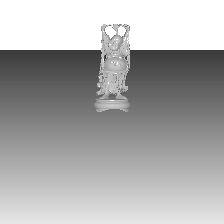

In [8]:
from IPython.display import Image
df2 = pd.read_csv(Global.csv_file)
print(df2.head(5))
fst_image = df2.iloc[0]['Filename']
Image(Global.image_dir + fst_image)

### Generierung Datenpipeline (Angepasst für Talos)

In [9]:
def create_data_pipline(batch_size, num_samples):
    
    
    df = pd.read_csv(Global.csv_file)
    df_shuffled = df.sample(frac = 1, random_state = 1)
    df_train = df_shuffled[0 : int(num_samples * 0.8 // batch_size * batch_size)]
    df_valid = df_shuffled.drop(df_shuffled.index[0 : df_train.shape[0]])[0 : int(num_samples * 0.2 // batch_size * batch_size)]
    #print(df_valid)
    
    if Global.data_augmentation:
        train_data_generator = ImageDataGenerator(
            rescale = 1./255,
            width_shift_range = 0.1,
            height_shift_range = 0.1,
            zoom_range = 0.1,
            brightness_range = (0.5, 1.0), 
            fill_mode = 'nearest'
        )
    else:
        train_data_generator = ImageDataGenerator(
            rescale = 1./255
        )
        
    train_generator = train_data_generator.flow_from_dataframe(
        dataframe = df_train,
        directory = Global.image_dir,
        x_col = 'Filename',
        y_col = ['Elevation', 'Azimuth'],
        class_mode = 'raw',
        target_size = (224, 224),
        color_mode = Global.image_channels,
        shuffle = True,
        seed = 77,
        batch_size = batch_size
    )
    #print(df_train)
        
    valid_data_generator = ImageDataGenerator(
        rescale = 1./255
    )
    
    valid_generator = valid_data_generator.flow_from_dataframe(
        dataframe = df_valid,
        directory = Global.image_dir,
        x_col = 'Filename',
        y_col = ['Elevation', 'Azimuth'],
        class_mode = 'raw',
        target_size = (224, 224),
        color_mode = Global.image_channels,
        shuffle = False,
        seed = 77,
        batch_size = batch_size
    )
    #print(df_train)
    
    return train_generator, valid_generator

In [10]:
if(not os.path.exists(Global.target_dir)):
    os.makedirs(Global.target_dir)
else:
    input('Directory >>| {} |<< existiert bereits. Fortsetzen auf eigene Gefahr! (Weiter mit Enter)'.format(Global.target_dir))

device_file = open(Global.target_dir + '{}.txt'.format(Global.device), "a+")
device_file.close()

Directory >>| ..\output\201019_2253_final_rgba\ |<< existiert bereits. Fortsetzen auf eigene Gefahr! (Weiter mit Enter)


### GridSerach Parameter

In [11]:
#     Adam = RMSprop + Momentum (lr=0.001)
#     Nadam = Adam RMSprop + Nesterov-Momentum (lr=0.002)
#     RMSprop = (lr=0.001)
#     SGD = (lr=0.01)
#     Adagrad

hyper_parameter = {
    'samples': [20000],
    'epochs': [1],
    'batch_size': [32, 64],
    'optimizer': [Adam],
    'lr': [1, 2, 3, 5],
    'first_neuron': [1024, 2048, 4096],
    'dropout': [0.25, 0.50],
    'activation': ['leakyrelu', 'relu'],
    'hidden_layers': [0, 1, 2, 3, 4],
    'leaky_alpha': [0.1] #Default bei LeakyReLU, sonst PReLU
}

hyper_parameter = {
    'samples': [20000],
    'epochs': [1],
    'batch_size': [32, 64],
    'optimizer': [Adam],
    'lr': [1, 2],
    'first_neuron': [1024, 2048, 4096],
    'dropout': [0.25, 0.50],
    'activation': ['leakyrelu', 'relu'],
    'hidden_layers': [0, 1, 2, 3, 4],
    'leaky_alpha': [0.1] #Default bei LeakyReLU, sonst PReLU
}

In [12]:
def gen_model_process(x_train, y_train, x_val, y_val, params):
    from multiprocessing import Process
    
    ret_value = multiprocessing.Value(x_train, y_train, x_val, y_val, params)

    reader_process = multiprocessing.Process(target=gen_model2, args=[ret_value])

    reader_process.start()

    reader_process.join()
    return ret_value.value

### Start Talos Search

In [13]:
dummy_x = np.empty((1, 2, 3, 224, 224))
dummy_y = np.empty((1, 2))

with tf.device('/device:GPU:0'):
    
        t = ta.Scan(
            x = dummy_x,
            y = dummy_y,
            model = gen_model_process,
            params = hyper_parameter,
            experiment_name = '{}'.format(Global.dataset),
            #shuffle=False,
            reduction_metric = Global.reduction_metric,
            disable_progress_bar = False,
            print_params = True,
            clear_session = True,
            save_weights = False
        )
        

t.data.to_csv(Global.target_dir + Global.results, index = True)

  0%|                                                                                          | 0/240 [00:00<?, ?it/s]

{'activation': 'leakyrelu', 'batch_size': 32, 'dropout': 0.25, 'epochs': 1, 'first_neuron': 1024, 'hidden_layers': 0, 'leaky_alpha': 0.1, 'lr': 1, 'optimizer': <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'>, 'samples': 20000}


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
#dummy_x = np.empty((1, 2, 3, 224, 224))
#dummy_y = np.empty((1, 2))
#
#from multiprocessing.pool import ThreadPool
#pool = ThreadPool(processes=1)
#
#
#with tf.device('/device:GPU:0'):
#    
#        t = ta.Scan(
#            x = dummy_x,
#            y = dummy_y,
#            model = gen_model_thread,
#            params = hyper_parameter,
#            experiment_name = '{}'.format(Global.dataset),
#            #shuffle=False,
#            reduction_metric = Global.reduction_metric,
#            disable_progress_bar = False,
#            print_params = True,
#            clear_session = True,
#            save_weights = False
#        )
#        
#
#t.data.to_csv(Global.target_dir + Global.results, index = True)

### Top Ergebnisse